In [1]:
# import needed libraries 
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models, optimizers, regularizers
from sklearn.metrics import classification_report, confusion_matrix
import keras_tuner as kt
import shutil
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

2025-04-10 15:41:32.348675: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 15:41:32.430376: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-10 15:41:32.430493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-10 15:41:32.436469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 15:41:32.455720: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 15:41:32.457000: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
from pathlib import Path

# ensure directories exist
Path("data/hurricane-cnn-split/train/damage").mkdir(parents=True, exist_ok=True)
Path("data/hurricane-cnn-split/train/no_damage").mkdir(parents=True, exist_ok=True)

Path("data/hurricane-cnn-split/test/damage").mkdir(parents=True, exist_ok=True)
Path("data/hurricane-cnn-split/test/no_damage").mkdir(parents=True, exist_ok=True)

In [3]:
damage_dir = 'coe379L-sp25/datasets/unit03/Project3/damage'
no_damage_dir = 'coe379L-sp25/datasets/unit03/Project3/no_damage'

# load only files (skip directories like .ipynb_checkpoints)
all_damage_file_paths = [f for f in os.listdir(damage_dir) if os.path.isfile(os.path.join(damage_dir, f))]
all_no_damage_file_paths = [f for f in os.listdir(no_damage_dir) if os.path.isfile(os.path.join(no_damage_dir, f))]

In [4]:
import random 

train_damage_paths = random.sample(all_damage_file_paths, int(len(all_damage_file_paths) * 0.8))
test_damage_paths = [p for p in all_damage_file_paths if p not in train_damage_paths]
print("Train damage image count:", len(train_damage_paths))
print("Test damage image count:", len(test_damage_paths))
print("Overlap (damage):", len([p for p in train_damage_paths if p in test_damage_paths]))

train_no_damage_paths = random.sample(all_no_damage_file_paths, int(len(all_no_damage_file_paths) * 0.8))
test_no_damage_paths = [p for p in all_no_damage_file_paths if p not in train_no_damage_paths]
print("Train no_damage image count:", len(train_no_damage_paths))
print("Test no_damage image count:", len(test_no_damage_paths))
print("Overlap (no_damage):", len([p for p in train_no_damage_paths if p in test_no_damage_paths]))

# clean existing split directory if present
try:
    shutil.rmtree("data/hurricane-cnn-split/train")
    shutil.rmtree("data/hurricane-cnn-split/test")
except:
    pass

# Helper function to copy files
def copy_files(file_list, src_dir, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)
    for filename in file_list:
        shutil.copy(os.path.join(src_dir, filename), os.path.join(dest_dir, filename))

Train damage image count: 11336
Test damage image count: 2834
Overlap (damage): 0
Train no_damage image count: 5721
Test no_damage image count: 1431
Overlap (no_damage): 0


In [5]:
# copy to new structure
copy_files(train_damage_paths, damage_dir, "data/hurricane-cnn-split/train/damage")
copy_files(test_damage_paths, damage_dir, "data/hurricane-cnn-split/test/damage")

copy_files(train_no_damage_paths, no_damage_dir, "data/hurricane-cnn-split/train/no_damage")
copy_files(test_no_damage_paths, no_damage_dir, "data/hurricane-cnn-split/test/no_damage")

print("Train - damage:", len(os.listdir("data/hurricane-cnn-split/train/damage")))
print("Train - no_damage:", len(os.listdir("data/hurricane-cnn-split/train/no_damage")))
print("Test - damage:", len(os.listdir("data/hurricane-cnn-split/test/damage")))
print("Test - no_damage:", len(os.listdir("data/hurricane-cnn-split/test/no_damage")))

Train - damage: 11336
Train - no_damage: 5721
Test - damage: 2834
Test - no_damage: 1431


In [6]:
# import necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Rescaling

# path to hurricane training data
train_data_dir = 'data/hurricane-cnn-split/train'

# image loading parameters
batch_size = 32
img_height = 150
img_width = 150

# load training and validation datasets from the hurricane data directory
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# create a Rescaling instance
rescale = Rescaling(scale=1.0/255)

# apply rescaling to the image datasets
train_rescale_ds = train_ds.map(lambda image, label: (rescale(image), label))
val_rescale_ds = val_ds.map(lambda image, label: (rescale(image), label))

Found 17057 files belonging to 2 classes.
Using 13646 files for training.
Using 3411 files for validation.


In [7]:
# path to hurricane test data
test_data_dir = 'data/hurricane-cnn-split/test/'

# load test dataset (no validation split here)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

# rescale test dataset
rescale = Rescaling(scale=1.0/255)
test_rescale_ds = test_ds.map(lambda image, label: (rescale(image), label))

Found 4265 files belonging to 2 classes.


In [8]:
# check class names for dataset
class_names = train_ds.class_names
print(class_names)

['damage', 'no_damage']


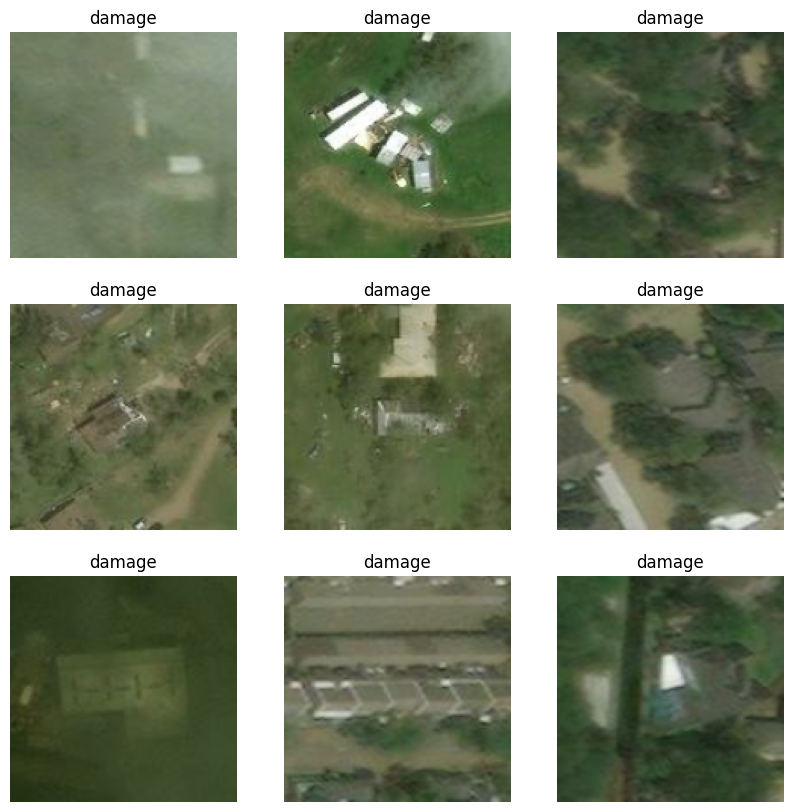

In [9]:
# print some pictures to check the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_rescale_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
from tensorflow.keras import Sequential, layers, optimizers
# Fully Connected ANN
ann_model = Sequential([
    layers.Flatten(input_shape=(150, 150, 3)),         
    layers.Dense(512, activation='relu'),              
    layers.Dense(256, activation='relu'),             
    layers.Dense(1, activation='sigmoid')              
])

# compile model
ann_model.compile(
    optimizer=optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# model summary
ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 512)               34560512  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 34692097 (132.34 MB)
Trainable params: 34692097 (132.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# lenet-5 CNN architecture

lenet_model = Sequential([
    layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    
    layers.Dense(1, activation='sigmoid')
])

# compile model
lenet_model.compile(
    optimizer=optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# model summary
lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 18496)             0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [12]:
hp = kt.HyperParameters()

# CNN architecture
alt_lenet_model = Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

# compile model
alt_lenet_model.compile(
    optimizer=optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# model summary
alt_lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 17, 17, 128)      

In [13]:
# run the model
history_ann = ann_model.fit(
    train_rescale_ds,
    batch_size=32,
    epochs=10,
    validation_data=val_rescale_ds
)

Epoch 1/10
427/427 [==============================] - 90s 208ms/step - loss: 1.5971 - accuracy: 0.6181 - val_loss: 0.5895 - val_accuracy: 0.7221
Epoch 2/10
427/427 [==============================] - 88s 205ms/step - loss: 0.5941 - accuracy: 0.6947 - val_loss: 0.5596 - val_accuracy: 0.7153
Epoch 3/10
427/427 [==============================] - 89s 208ms/step - loss: 0.5681 - accuracy: 0.7194 - val_loss: 0.6628 - val_accuracy: 0.6755
Epoch 4/10
427/427 [==============================] - 89s 208ms/step - loss: 0.5537 - accuracy: 0.7301 - val_loss: 0.5623 - val_accuracy: 0.7256
Epoch 5/10
427/427 [==============================] - 90s 212ms/step - loss: 0.5498 - accuracy: 0.7425 - val_loss: 0.6718 - val_accuracy: 0.6737
Epoch 6/10
427/427 [==============================] - 90s 210ms/step - loss: 0.6028 - accuracy: 0.6990 - val_loss: 0.6359 - val_accuracy: 0.6681
Epoch 7/10
427/427 [==============================] - 90s 211ms/step - loss: 0.6210 - accuracy: 0.6844 - val_loss: 0.6355 - val_ac

In [15]:
# run the model
history_lenet = lenet_model.fit(
    train_rescale_ds,
    batch_size=32,
    validation_data=val_rescale_ds,
    epochs=10
)

Epoch 1/10
427/427 [==============================] - 62s 144ms/step - loss: 0.3896 - accuracy: 0.8402 - val_loss: 0.2452 - val_accuracy: 0.9038
Epoch 2/10
427/427 [==============================] - 62s 144ms/step - loss: 0.2138 - accuracy: 0.9183 - val_loss: 0.1928 - val_accuracy: 0.9249
Epoch 3/10
427/427 [==============================] - 62s 145ms/step - loss: 0.1656 - accuracy: 0.9341 - val_loss: 0.2504 - val_accuracy: 0.9220
Epoch 4/10
427/427 [==============================] - 61s 143ms/step - loss: 0.1147 - accuracy: 0.9552 - val_loss: 0.2077 - val_accuracy: 0.9317
Epoch 5/10
427/427 [==============================] - 62s 145ms/step - loss: 0.0774 - accuracy: 0.9726 - val_loss: 0.1924 - val_accuracy: 0.9405
Epoch 6/10
427/427 [==============================] - 61s 143ms/step - loss: 0.0464 - accuracy: 0.9839 - val_loss: 0.2171 - val_accuracy: 0.9440
Epoch 7/10
427/427 [==============================] - 62s 145ms/step - loss: 0.0315 - accuracy: 0.9883 - val_loss: 0.2298 - val_ac

In [16]:
# run the model
history_alt_lenet = alt_lenet_model.fit(
    train_rescale_ds,
    batch_size=32,
    validation_data=val_rescale_ds,
    epochs=10,
)

Epoch 1/10
427/427 [==============================] - 133s 309ms/step - loss: 0.6556 - accuracy: 0.7983 - val_loss: 0.2237 - val_accuracy: 0.9349
Epoch 2/10
427/427 [==============================] - 132s 308ms/step - loss: 0.2306 - accuracy: 0.9309 - val_loss: 0.1689 - val_accuracy: 0.9513
Epoch 3/10
427/427 [==============================] - 134s 313ms/step - loss: 0.1999 - accuracy: 0.9427 - val_loss: 0.1560 - val_accuracy: 0.9566
Epoch 4/10
427/427 [==============================] - 134s 314ms/step - loss: 0.1881 - accuracy: 0.9442 - val_loss: 0.1815 - val_accuracy: 0.9449
Epoch 5/10
427/427 [==============================] - 134s 315ms/step - loss: 0.1765 - accuracy: 0.9469 - val_loss: 0.1396 - val_accuracy: 0.9590
Epoch 6/10
427/427 [==============================] - 134s 314ms/step - loss: 0.1583 - accuracy: 0.9551 - val_loss: 0.1412 - val_accuracy: 0.9613
Epoch 7/10
427/427 [==============================] - 133s 311ms/step - loss: 0.1578 - accuracy: 0.9558 - val_loss: 0.1689 -

In [17]:
# testing accuracy

test_loss_ann, test_acc_ann = ann_model.evaluate(val_rescale_ds)
test_loss_lenet, test_acc_lenet = lenet_model.evaluate(val_rescale_ds)
test_loss_alt_lenet, test_acc_alt_lenet = alt_lenet_model.evaluate(val_rescale_ds)

print(f"ANN Test Accuracy: {test_acc_ann:.4f}")
print(f"LeNet-5 Test Accuracy: {test_acc_lenet:.4f}")
print(f"Alternate LeNet-5 Test Accuracy: {test_acc_alt_lenet:.4f}")

107/107 [==============================] - 8s 75ms/step - loss: 0.1154 - accuracy: 0.9733
ANN Test Accuracy: 0.6681
LeNet-5 Test Accuracy: 0.9346
Alternate LeNet-5 Test Accuracy: 0.9733


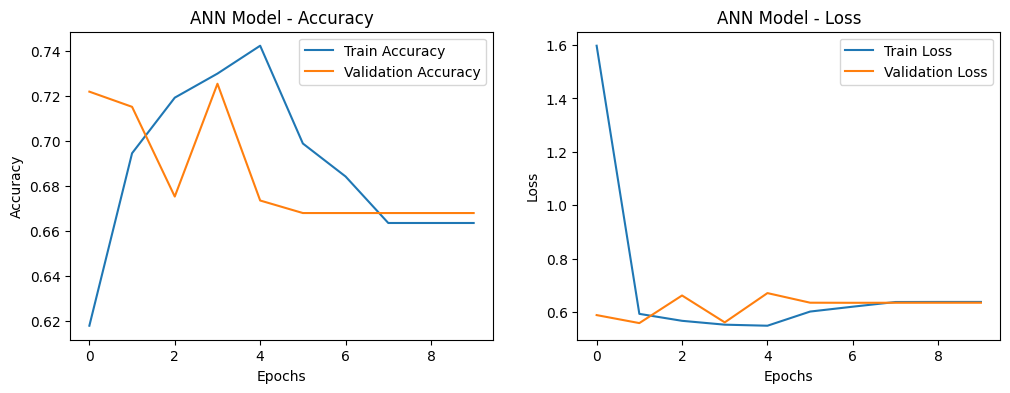

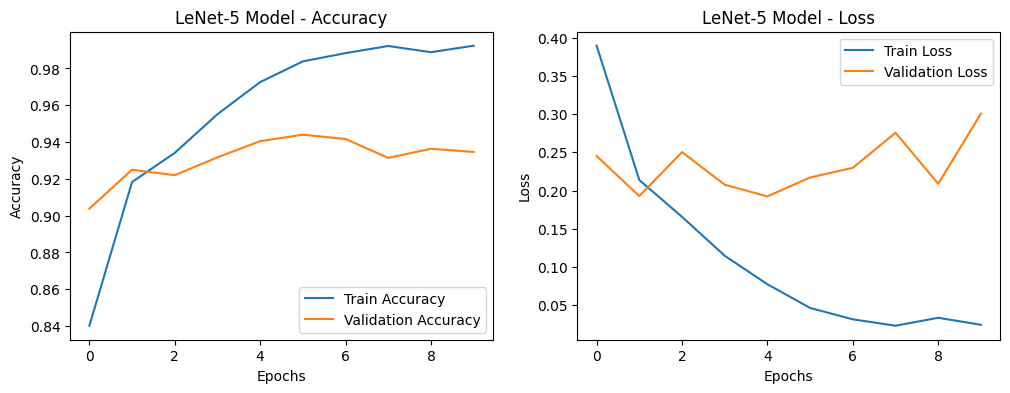

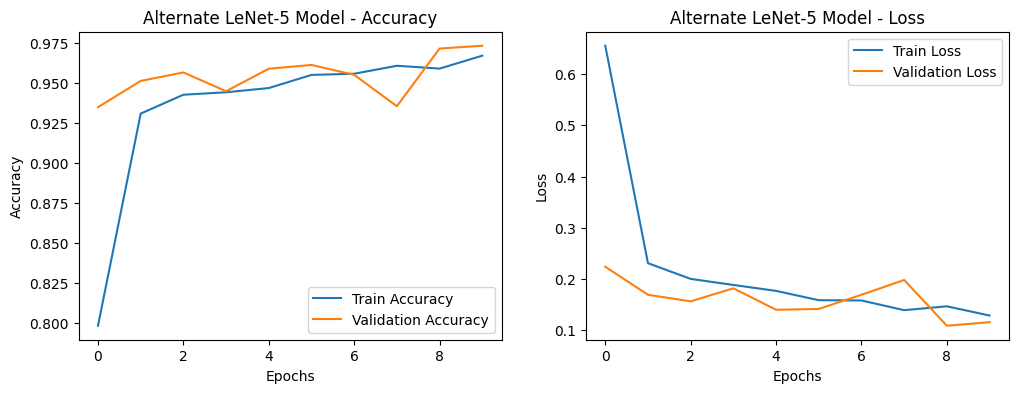

In [18]:
import matplotlib.pyplot as plt

def plot_metrics(history, title):
    plt.figure(figsize=(12, 4))

    # plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# plot performance for each model
plot_metrics(history_ann, "ANN Model")
plot_metrics(history_lenet, "LeNet-5 Model")
plot_metrics(history_alt_lenet, "Alternate LeNet-5 Model")

In [19]:
# find the best model
best_model = None
best_accuracy = max(test_acc_ann, test_acc_lenet, test_acc_alt_lenet)

if best_accuracy == test_acc_ann:
    best_model = ann_model
    model_name = "ANN Model"
elif best_accuracy == test_acc_lenet:
    best_model = lenet_model
    model_name = "LeNet-5 Model"
else:
    best_model = alt_lenet_model
    model_name = "Alternate LeNet-5 Model"

print(f"Best Model: {model_name} with Accuracy: {best_accuracy:.4f}")


Best Model: Alternate LeNet-5 Model with Accuracy: 0.9733


In [20]:
# same the best model
alt_lenet_model.save('best_damage_classification_model.keras')
print("Saved the best model as 'best_damage_classification_model.keras'")

Saved the best model as 'best_damage_classification_model.keras'


In [21]:
# test if saved model works
import tensorflow as tf

# load the trained model
model = tf.keras.models.load_model("best_damage_classification_model.keras") 

# evaluate on training data
print(train_rescale_ds)
train_results = model.evaluate(train_rescale_ds, verbose=1)
print("Training Results:", train_results)

# evaluate on validation data
val_results = model.evaluate(val_rescale_ds, verbose=1)
print("Validation Results:", val_results)

# evaluate on validation data
test_results = model.evaluate(test_rescale_ds, verbose=1)
print("Test Results:", test_results)

<_MapDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
427/427 [==============================] - 33s 76ms/step - loss: 0.1112 - accuracy: 0.9765
Training Results: [0.11124402284622192, 0.9764766097068787]
107/107 [==============================] - 8s 76ms/step - loss: 0.1154 - accuracy: 0.9733
Validation Results: [0.11535349488258362, 0.9733216166496277]
134/134 [==============================] - 10s 76ms/step - loss: 0.1112 - accuracy: 0.9780
Test Results: [0.11118292063474655, 0.9779601693153381]


1/1 [==============================] - 0s 106ms/step
[[0.9992164]]


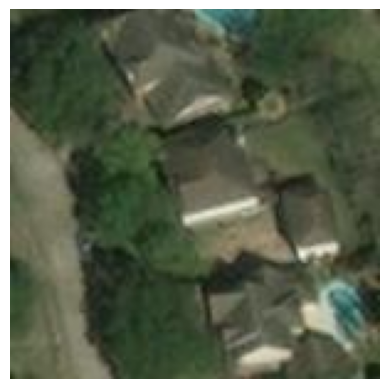

0.9992164


{'probability_no_damage': 0.9992163777351379, 'prediction': 'No_Damage'}

In [22]:
# test if the model works on a single image
import numpy as np 
from PIL import Image
# path= 'coe379L-sp25/code/Project3/data/damage/-93.73643_29.788717.jpeg'
path='coe379L-sp25/code/Project3/data/no_damage/-95.6302_29.768889.jpeg'
    # img = Image.open(path)
    # img = np.asarray(img)
    # return img.tolist()
img = Image.open(path).resize((150, 150))
img_array = np.array(img) / 255.0
img_list = np.expand_dims(img_array, axis=0).tolist()
# perform inference using the pre-trained model
prediction = model.predict(img_list)
print(prediction)

# show the first (and only) image
plt.imshow(img_list[0])  
plt.axis('off')
plt.show()

# extract the probability of being damaged
probability_damaged = prediction[0][0]
print(probability_damaged)

# Determine the class based on the threshold
threshold = 0.5
if probability_damaged >= threshold:
    prediction_label = 'No_Damage'
else:
    prediction_label = 'Damage'

# convert the prediction result into a JSON format
result = {
    'probability_no_damage': float(probability_damaged),
    'prediction': prediction_label
}

result

In [23]:
import requests

import numpy as np 
from PIL import Image
path= 'coe379L-sp25/code/Project3/data/no_damage/-95.6302_29.768889.jpeg'

# create the files dictionary
data = {"image": open(path, 'rb')}

 # send the POST request
rsp = requests.post("http://172.17.0.1:5000/inference", files=data)

img = Image.open(path).resize((150, 150))
img = np.array(img) / 255.0
img_list = np.expand_dims(img_array, axis=0).tolist()

# make the POST request passing the sinlge test case as the `image` field:
# rsp = requests.post("http://172.17.0.1:5000/inference", json={"image": img_array})

# print the json response
rsp.json()

{'confidence': 0.9998849630355835, 'prediction': 'No_Damage'}